In [1]:
import os
import shutil
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import torch
import einops
import numpy as np
from PIL import Image
from pytorch_lightning import seed_everything
import torchvision.transforms as transformers

from enum import Enum
from ControlNet.cldm.model import create_model,load_state_dict
from ControlNet.annotator.canny import CannyDetector
from ControlNet.annotator.util import HWC3
from safetensors.torch import load_file

from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.img_util import find_flat_region, numpy2tensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
eta = 0.0

/home/yfyuan/anaconda3/envs/semantic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from einops import rearrange
from visualize import visualize_grid_attention_v2
from torchvision import transforms as T
from sklearn.decomposition import PCA
from PIL import Image

In [4]:
model_dict = {
    'Stable Diffusion 1.5': '',
    'revAnimated_v11': 'models/revAnimated_v11.safetensors',
    'realisticVisionV20_v20': 'models/realisticVisionV20_v20.safetensors',
    'DGSpitzer/Cyberpunk-Anime-Diffusion': '~/YYF/all_models/Cyberpunk-Anime-Diffusion.safetensors',
    'wavymulder/Analog-Diffusion': 'analog-diffusion-1.0.safetensors',
    'Fictiverse/Stable_Diffusion_PaperCut_Model': '/home/yfyuan/YYF/all_models/papercut_v1.ckpt',
}
local_model = ['Fictiverse/Stable_Diffusion_PaperCut_Model', 'wavymulder/Analog-Diffusion', 'DGSpitzer/Cyberpunk-Anime-Diffusion']
class ProcessingState(Enum):
    NULL = 0
    FIRST_IMG = 1
    KEY_IMGS = 2
class GlobalState:

    def __init__(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        self.detector_type = None
        self.detector = None
        self.controller = None
        self.processing_state = ProcessingState.NULL

    def update_controller(self, inner_strength, mask_period, cross_period,
                          ada_period, warp_period):
        self.controller = AttentionControl(inner_strength, mask_period,
                                           cross_period, ada_period,
                                           warp_period)

    def update_sd_model(self, sd_model, control_type):
        if sd_model == self.sd_model:
            return
        self.sd_model = sd_model
        model = create_model('./ControlNet/models/cldm_v15.yaml').cpu()
        if control_type == 'HED':
            model.load_state_dict(
                load_state_dict(huggingface_hub.hf_hub_download(
                    'lllyasviel/ControlNet', './models/control_sd15_hed.pth'),
                    location=device))
        elif control_type == 'canny':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_canny.pth',
                                location=device))
        elif control_type == 'depth':
            model.load_state_dict(
                load_state_dict(huggingface_hub.hf_hub_download(
                    'lllyasviel/ControlNet', 'models/control_sd15_depth.pth'),
                    location=device))

        model.to(device)
        sd_model_path = model_dict[sd_model]
        if len(sd_model_path) > 0:
            # check if sd_model is repo_id/name otherwise use global REPO_NAME
            if sd_model.count('/') == 1:
                repo_name = sd_model

            model_ext = os.path.splitext(sd_model_path)[1]
            if model_ext == '.safetensors':
                model.load_state_dict(load_file(sd_model_path), strict=False)
            elif model_ext == '.ckpt' or model_ext == '.pth':
                model.load_state_dict(torch.load(sd_model_path)['state_dict'],
                                      strict=False)

        try:
            model.first_stage_model.load_state_dict(torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'],strict=False)
        except Exception:
            print('Warning: We suggest you download the fine-tuned VAE',
                  'otherwise the generation quality will be degraded')

        self.ddim_v_sampler = DDIMVSampler(model)

    def clear_sd_model(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        if device == 'cuda':
            torch.cuda.empty_cache()

    def update_detector(self, control_type, canny_low=100, canny_high=200):
        if self.detector_type == control_type:
            return
        if control_type == 'HED':
            self.detector = HEDdetector()
        elif control_type == 'canny':
            canny_detector = CannyDetector()
            low_threshold = canny_low
            high_threshold = canny_high

            def apply_canny(x):
                return canny_detector(x, low_threshold, high_threshold)

            self.detector = apply_canny

        elif control_type == 'depth':
            midas = MidasDetector()

            def apply_midas(x):
                detected_map, _ = midas(x)
                return detected_map

            self.detector = apply_midas

In [5]:
global_state = GlobalState()

# sd_model = 'revAnimated_v11'
sd_model = 'realisticVisionV20_v20' #真实风格
# sd_model = 'DGSpitzer/Cyberpunk-Anime-Diffusion' #赛博朋克风格
# sd_model = 'wavymulder/Analog-Diffusion' # 人物传记风格
# sd_model = 'Fictiverse/Stable_Diffusion_PaperCut_Model' # 剪纸风格
control_type = 'canny'
low_threshold = 50
high_threshold = 100

In [6]:
global_state.update_sd_model(sd_model, control_type)
global_state.update_controller(0,0,0,0,0)
# global_state.update_controller(0,0,0,0,0)
global_state.update_detector(control_type, low_threshold, high_threshold)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.8.mlp.fc2.bias', 'vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.20.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_at

Loaded model config from [./ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


/home/yfyuan/anaconda3/envs/semantic/lib/python3.8/site-packages/safetensors/torch.py:98: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:


In [15]:
%%capture
ddim_v_sampler = global_state.ddim_v_sampler
model = ddim_v_sampler.model
detector = global_state.detector
controller = global_state.controller
controller.set_task('')
model.control_scales = [0.9] * 13
model.to(device)

In [16]:
unet_model = model.model.diffusion_model

In [133]:
# 一个聚类问题明显的例子
dir_ = "starfish"
inv = "_inv"
inv = ""
feature_maps_path = f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/{dir_}"
feature_maps_path_inv = f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/{dir_}_inv"
feature_type = "input_block" # 1 2 4 5 7 8 10 11
feature_type = "output_block" # 0 1 2 up 3 4 5 up 6 7 8 up 9 10 11 
# block idx
# pos = "in"
pos = "out"
out = "out"
in_ = "in"
block_idx = 4
i = 50

# feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_layers_features_time_{i}.pt"))[0]
# feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_self_attn_time_{i}.pt"))[0]
# feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_trans_time_{i}.pt"))[0]
attn_out_4 = torch.load(os.path.join(feature_maps_path, f"output_block_{7}_{out}_trans_time_{i}.pt"))
down_out_6 = torch.load(os.path.join(feature_maps_path, f"input_block_{3}_downsample_output_time_{i}.pt"))
control_plus_down = torch.load(os.path.join(feature_maps_path, f"output_block_{8}_all_in_layers_features_time_{i}.pt"))[:,-down_out_6.shape[1]:,...]
emb_5 = torch.load(os.path.join(feature_maps_path, f"output_block_{8}_emb_layers_features_time_{i}.pt"))

print(control_plus_down.shape)
print(down_out_6.shape)
only_control_5 = control_plus_down - down_out_6

torch.Size([1, 320, 20, 28])
torch.Size([1, 320, 20, 28])


In [134]:
h = attn_out_4
print(h.shape)
h = torch.cat([h, down_out_6 + only_control_5], dim=1)
emb = emb_5

torch.Size([1, 640, 20, 28])


In [135]:
print(h.shape)
print(emb.shape)

torch.Size([1, 960, 20, 28])
torch.Size([1, 1280])


In [136]:
# out_res_module_5 = model.model.diffusion_model.output_blocks[5]
out_res_module_5 = model.model.diffusion_model.output_blocks[8][0]
out_sa_module_5 = model.model.diffusion_model.output_blocks[8][1]

In [137]:
out = out_res_module_5(h,emb,None)

In [138]:
out_sa_module_5(out)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (560x640 and 768x640)

In [139]:
attn_map = out_sa_module_5.transformer_blocks[0].attn1.tmp_sim
print(attn_map.shape)

torch.Size([8, 560, 560])


In [140]:
pca = PCA(n_components=3)
self_attn_map = rearrange(attn_map, 'h n m -> n (h m)')
self_attn_map = self_attn_map.cpu().numpy()
pca.fit(self_attn_map)

self_attn_map = pca.transform(self_attn_map)
self_attn_map = self_attn_map.reshape(1,-1,3)
b,n,f = self_attn_map.shape
print(b,n,f)

1 560 3


In [141]:
# pca_img = self_attn_map.reshape(12 * 2,14 * 2,3)
pca_img = self_attn_map.reshape(20, 28, 3)
# pca_img = self_attn_map.reshape(21 // 1,24 // 1,3)
pca_img_min = pca_img.min(axis=(0, 1))
pca_img_max = pca_img.max(axis=(0, 1))
pca_img = (pca_img - pca_img_min) / (pca_img_max - pca_img_min)
pca_img = Image.fromarray((pca_img * 255).astype(np.uint8))
pca_img = T.Resize(512, interpolation=T.InterpolationMode.NEAREST)(pca_img)

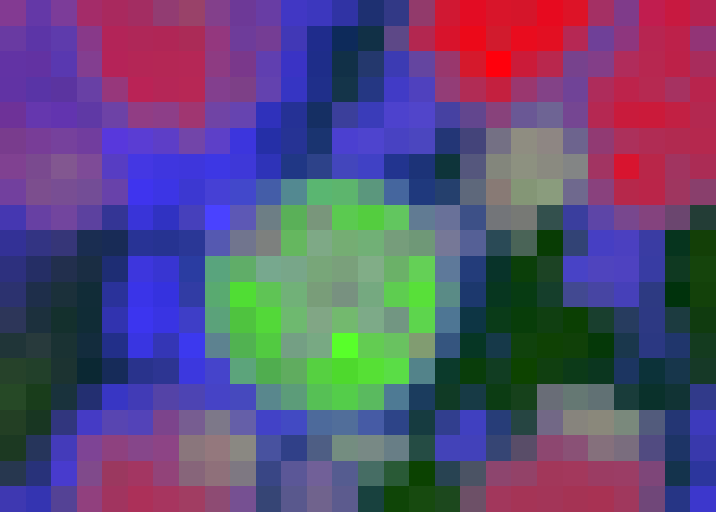

In [142]:
display(pca_img)

In [112]:
pca_img.save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_raw_attn.png")

In [1]:
a = range(1,1000, 1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
